# ABM results

In [85]:
import pandas as pd
import sys
sys.path.insert(0, "abetam")
from abetam.batch import BatchResult
from main import add_abm_demand_to_projection
result_path = "abetam/results/master/0a1d8cd9a096f9edb11679f1db00c3f3_0"
b_res = BatchResult.from_directory(result_path)
tech_share_fig = b_res.tech_shares_fig()


ImportError: cannot import name 'modify_carbon_tax' from 'scenarios' (c:\src\canadopt\abetam\scenarios\__init__.py)

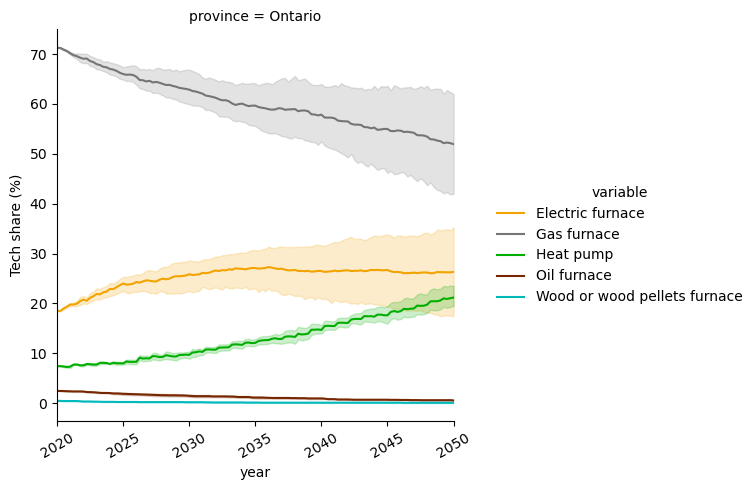

In [ ]:
tech_share_fig.fig.axes[0].set_xlim((2020, 2050))

tech_share_fig.figure

In [ ]:
import plotly.express as px
model_demand = b_res.mean_carrier_demand_df
energy_demand_df_long = model_demand.groupby(["province","year"]).sum().reset_index().melt(id_vars=["province","year"])

energy_demand_df_long["value"] = energy_demand_df_long["value"].astype(float)
energy_demand_df_long["fuel"] = energy_demand_df_long["variable"].str.split(".", expand=True)[0]

energy_demand_df_long


,province,year,variable,value,fuel
0,Ontario,2020.0,Fuels.NATURAL_GAS,9.273691e+10,Natural gas
1,Ontario,2025.0,Fuels.NATURAL_GAS,8.590769e+10,Natural gas
2,Ontario,2030.0,Fuels.NATURAL_GAS,8.188707e+10,Natural gas
3,Ontario,2035.0,Fuels.NATURAL_GAS,7.820968e+10,Natural gas
4,Ontario,2040.0,Fuels.NATURAL_GAS,7.594273e+10,Natural gas
5,Ontario,2045.0,Fuels.NATURAL_GAS,7.220131e+10,Natural gas
6,Ontario,2050.0,Fuels.NATURAL_GAS,6.811571e+10,Natural gas
7,Ontario,2020.0,Fuels.HEATING_OIL,3.261190e+09,Heating oil
8,Ontario,2025.0,Fuels.HEATING_OIL,2.498882e+09,Heating oil
9,Ontario,2030.0,Fuels.HEATING_OIL,1.852482e+09,Heating oil


In [ ]:
from abetam.figures import sciencify_plotly_fig
from abetam.config import FUEL_COLORS
fig = px.bar(
    energy_demand_df_long,
    x="year",
    y="value",
    color="fuel",
    color_discrete_map=FUEL_COLORS,
)
fig.update_layout(xaxis_title="Year", yaxis_title="Energy demand (kWh/a)", width=500, legend_traceorder="reversed")
sciencify_plotly_fig(fig)


In [ ]:
model_demand = b_res.mean_carrier_demand_df
new_demand = add_abm_demand_to_projection(model_demand)
abm_inkl_peaks = new_demand.max().reset_index()
abm_inkl_peaks[["province","year"]] = abm_inkl_peaks["index"].str.split(".",expand=True)
abm_inkl_peaks = abm_inkl_peaks.rename({0:"ABM_incl"}, axis=1).drop(["index","province"],axis=1)
abm_inkl_peaks

,ABM_incl,year
0,20153.212295,2020
1,23427.833787,2025
2,28218.998288,2030
3,34389.004031,2035
4,39840.216979,2040
5,44018.701047,2045
6,47290.178604,2050


In [ ]:
copper_demand_projection = pd.read_csv("copper/results/BAU_scenario_20240315_1125/demand_df_user_demand=False.csv")
copper_demand_projection.columns = ["year","hour"] + copper_demand_projection.columns[2:].to_list()
copper_demand_projection["Ontario"] = copper_demand_projection["Ontario.a"] + copper_demand_projection["Ontario.b"]

copper_demand_peaks = copper_demand_projection.groupby(["year"]).max()["Ontario"].reset_index()
copper_demand_peaks = copper_demand_peaks.rename({"Ontario":"COPPER projection"}, axis=1)
copper_demand_peaks.melt(id_vars="year")

,year,variable,value
0,2025,COPPER projection,23836.863269
1,2030,COPPER projection,25113.331501
2,2035,COPPER projection,26578.906183
3,2040,COPPER projection,29056.200162
4,2045,COPPER projection,30619.891274
5,2050,COPPER projection,32917.383850


In [ ]:
import plotly.express as px
from abetam.figures import sciencify_plotly_fig
both_demands = pd.concat([abm_inkl_peaks.melt(id_vars="year"),copper_demand_peaks.melt(id_vars="year")])
fig = sciencify_plotly_fig(px.line(both_demands, x="year", y="value", color="variable", template="plotly"))
fig.update_layout(yaxis_title="Peak demand (MW)") 

# Results of the coupled model

In [ ]:
from pathlib import Path
import pandas as pd

def copper_result_dir(abm_result_dir: Path):
    scen_date, iteration = abm_result_dir.stem.rsplit("_",1)
    result_dirs = list(Path(f"copper/results/{scen_date}").iterdir())
    result_dirs = sorted(result_dirs)
    return result_dirs[int(iteration)]

abm_result_dirs = Path("results").iterdir()
date = "20240415"
abm_result_dirs = [d for d in abm_result_dirs if date in d.name]
# abm_result_dirs
result_df = pd.DataFrame(list([(d, copper_result_dir(d)) for d in sorted(abm_result_dirs)]), columns=["ABM path", "ESM path"])
result_df["iteration"] = result_df["ABM path"].apply( lambda p: p.stem.rsplit("_",1)[-1]).astype(int)

result_df["Scenario"] = result_df["ABM path"].apply( lambda p: p.stem.split("_",1)[0])

scen_mod = result_df["ABM path"].apply(lambda p: "+" if "_plus" in p.stem else "")

result_df["Scenario"] = result_df["Scenario"] + scen_mod

result_df

,ABM path,ESM path,iteration,Scenario
0,results\BAU_20240415_2139_0,copper\results\BAU_20240415_2139\BAU_scenario_...,0,BAU
1,results\BAU_20240415_2139_1,copper\results\BAU_20240415_2139\BAU_scenario_...,1,BAU
2,results\CER_20240415_2156_0,copper\results\CER_20240415_2156\CER_scenario_...,0,CER
3,results\CER_20240415_2156_1,copper\results\CER_20240415_2156\CER_scenario_...,1,CER
4,results\CER_plus_20240415_2213_0,copper\results\CER_plus_20240415_2213\CER_scen...,0,CER+
5,results\CER_plus_20240415_2213_1,copper\results\CER_plus_20240415_2213\CER_scen...,1,CER+
6,results\Rapid_20240415_2231_0,copper\results\Rapid_20240415_2231\CER_scenari...,0,Rapid
7,results\Rapid_20240415_2231_1,copper\results\Rapid_20240415_2231\CER_scenari...,1,Rapid


In [ ]:
# # zip all the results
# from zipfile import ZipFile, ZIP_DEFLATED
# from pathlib import Path

# with ZipFile("results.zip","w", compression=ZIP_DEFLATED, compresslevel=9) as zf:
#     for path in result_df["ABM path"]:
#         for f in path.rglob("*"):
#             zf.write(f, f)
#     for path in result_df["ESM path"]:
#         for f in path.rglob("*"):
#             zf.write(f, f)


In [ ]:
# from zipfile import ZipFile
# from pathlib import Path

# # unzip all the results
# filenames :list[str]= []
# with ZipFile("results_240415","r") as zf:
#     file_list = zf.filelist
#     for f in file_list:
#         fn = f.filename
#         zf.extract(f,)
#         filenames.append(fn)

## ABM Adoption and energy demands

In [ ]:
import sys 
sys.path.insert(0,"abetam")
from abetam.batch import BatchResult
import seaborn as sns

tech_share_dfs = []
fuel_demands = []
subsidy_dfs = []
emission_dfs = []

for scenario in result_df.Scenario.unique():
    # print(scenario,":", result_df.query(f"iteration==1 and Scenario=='{scenario}'"))
    abm_res = BatchResult.from_directory(result_df.query(f"iteration==1 and Scenario=='{scenario}'")["ABM path"].values[0])
    t_share_df = abm_res.tech_shares_df
    t_share_df["scenario"] = scenario
    tech_share_dfs.append(t_share_df)

    demands = abm_res.mean_carrier_demand_df.copy()
    demands["scenario"] = scenario
    fuel_demands.append(demands)

    subs = abm_res.subsidies_df
    subs["scenario"] = scenario
    subsidy_dfs.append(subs)

    emiss = abm_res.emissions()
    emiss["scenario"] = scenario
    emission_dfs.append(emiss)


scenario_tech_shares = pd.concat(tech_share_dfs)
scenario_fuel_demands = pd.concat(fuel_demands)
scenario_emissions = pd.concat(emission_dfs)
scenario_subsidies = pd.concat(subsidy_dfs)


scenario_emissions.head()


,Fuels.ELECTRICITY,Fuels.HEATING_OIL,Fuels.NATURAL_GAS,Fuels.WOOD_OR_WOOD_PELLETS,scenario
2020,0.459921,1.558344,18.607844,0.092339,BAU
2021,0.465459,1.499977,18.425672,0.085627,BAU
2022,0.470997,1.441609,18.243500,0.078916,BAU
2023,0.476535,1.383242,18.061327,0.072205,BAU
2024,0.482074,1.324874,17.879155,0.065494,BAU


In [ ]:
scenario_fuel_demands_long = scenario_fuel_demands.groupby(["year","scenario"]).sum().melt(ignore_index=False).reset_index()
scenario_fuel_demands_long["value"] /= 1e9 # kWh -> TWh
scenario_fuel_demands_long.head()

,year,scenario,variable,value
0,2020.0,BAU,Fuels.NATURAL_GAS,93.039222
1,2020.0,CER,Fuels.NATURAL_GAS,92.543851
2,2020.0,CER+,Fuels.NATURAL_GAS,92.681349
3,2020.0,Rapid,Fuels.NATURAL_GAS,92.384551
4,2025.0,BAU,Fuels.NATURAL_GAS,88.484914


In [ ]:
from abetam.config import TECHNOLOGY_COLORS, FUEL_COLORS
from abetam.components.technologies import Fuels
ABM_colors = dict(TECHNOLOGY_COLORS, **FUEL_COLORS)

scenario_tech_shares_long = scenario_tech_shares.drop(["province","RunId"], axis=1).melt(id_vars=["year","scenario"]) 
abm_results = pd.concat([scenario_tech_shares_long, scenario_fuel_demands_long])
def is_fuel(v):
    return v in list(Fuels)
abm_results["is_demand"] = abm_results["variable"].apply(is_fuel)

abm_results["variable"] = abm_results["variable"].str.replace("Wood or wood pellets", "Biomass")
ABM_colors["Biomass furnace"] = ABM_colors["Wood or wood pellets furnace"]
ABM_colors["Biomass"] = ABM_colors["Wood or wood pellets"]
abm_results.tail()



,year,scenario,variable,value,is_demand
107,2045.0,Rapid,Electricity,17.576122,True
108,2050.0,BAU,Electricity,50.354886,True
109,2050.0,CER,Electricity,45.006742,True
110,2050.0,CER+,Electricity,59.57767,True
111,2050.0,Rapid,Electricity,17.791595,True


0 False BAU 3630


1 False CER 3630
2 False CER+ 3630
3 False Rapid 3630
4 True BAU 28
5 True CER 28
6 True CER+ 28
7 True Rapid 28


[]

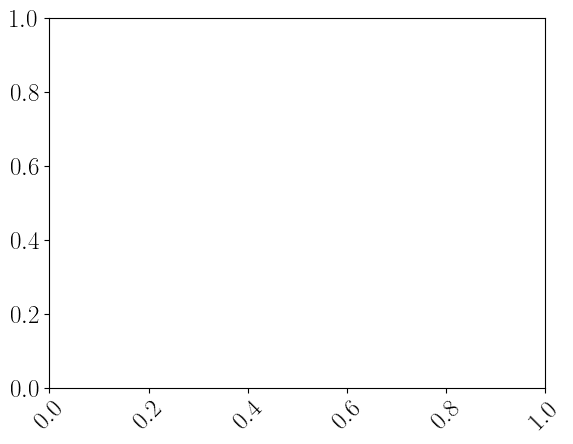

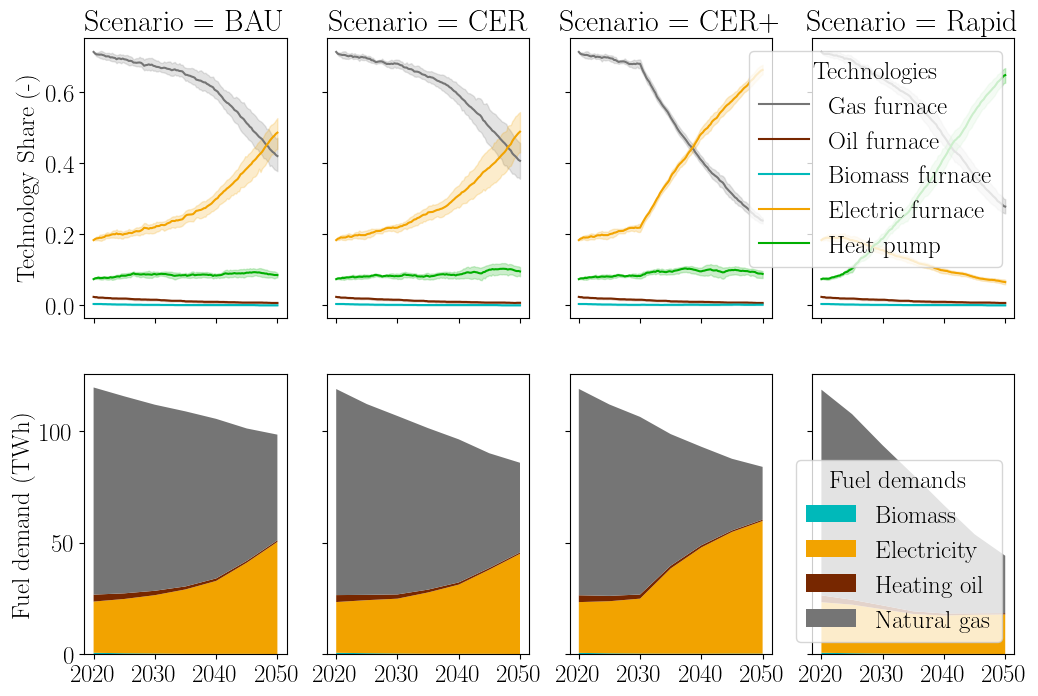

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "cm"
plt.rcParams["font.size"] = "18"
plt.rcParams['svg.fonttype'] = 'none'

plt.xticks(rotation=45)
fuel_name_map = dict(zip(Fuels, [x.value for x in Fuels]))
fuel_name_map["Biomass"] = "Biomass"

abm_fig, axs = plt.subplots(ncols=4, nrows=2,  sharex='all', sharey='row', figsize=(12,8))
for i,(dem_scen, df) in enumerate(abm_results.groupby(["is_demand","scenario"])):
    print(i,dem_scen[0],dem_scen[1],len(df))
    ax = axs.flat[i]
    if not dem_scen[0]:
        ax.title.set_text(f"Scenario = {dem_scen[1]}")
        show_legend = i==3
        sns.lineplot(data=df, x="year", y="value", hue="variable", palette=ABM_colors, ax=ax, legend=show_legend)
        if show_legend:
            ax.get_legend().set_title("Technologies")
    else:
        show_legend = i==7
        wide_df = df.pivot(columns="variable", values="value", index="year")
        wide_columns = wide_df.columns
        column_vals = [wide_df[col].astype(float) for col in wide_columns]
        ax.stackplot(wide_df.index, *column_vals, colors=[ABM_colors[col] for col in wide_columns], labels=[fuel_name_map[col] for col in wide_columns])
        if show_legend:
            ax.legend(loc="lower right")
            ax.get_legend().set_title("Fuel demands")


abm_fig.axes[0].set_ylabel("Technology Share (-)")
abm_fig.axes[4].set_ylabel("Fuel demand (TWh)")
abm_fig.axes[0].set_xticks(range(2020,2051,10))
abm_fig.axes[0].set_xticklabels(range(2020,2051,10))


## ABM: Emissions and subsidies

In [ ]:
total_scenario_emissions = scenario_emissions.reset_index().groupby(["index","scenario"]).sum().sum(axis=1).reset_index()
total_scenario_emissions["cumulative"] = total_scenario_emissions.groupby("scenario").cumsum()[0]
# px.line(total_scenario_emissions, x="index", y="cumulative", color="scenario", template="plotly")

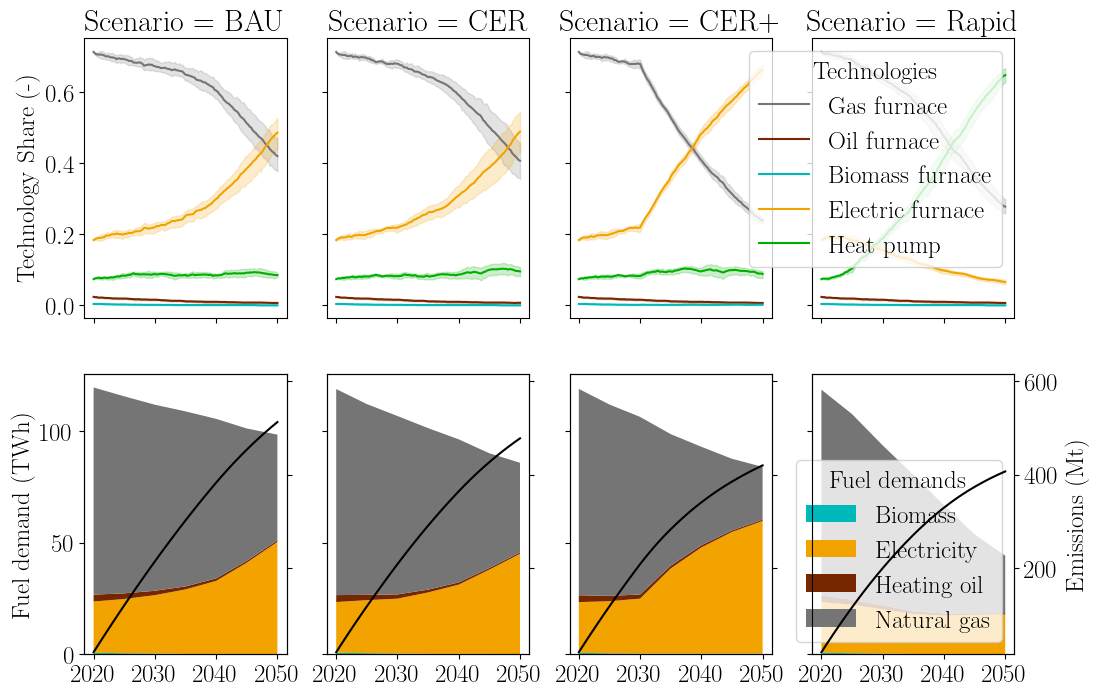

In [ ]:
em_y_lim = total_scenario_emissions.cumulative.min()*0.8, total_scenario_emissions.cumulative.max()*1.2
emission_color = "black"
for i, (scen, df) in enumerate(total_scenario_emissions.groupby("scenario")):
    # print(scen, df)
    t_ax = axs.flat[4+i].twinx()
    t_ax.plot(df["index"],df["cumulative"], color=emission_color)
    t_ax.set_ylim(*em_y_lim)
    t_ax.spines["right"].set_color(emission_color)
    t_ax.tick_params(colors=emission_color, which='both')
    last = i==3
    if not last:
        t_ax.set_yticklabels([])
    else:
        t_ax.set_ylabel("Emissions (Mt)")
abm_fig.savefig("abm_results.svg")
abm_fig

In [ ]:
import plotly.express as px
subsidies_plot_df = scenario_subsidies.groupby(["year","scenario"])[["hp specific cost", "Cumulative subsidy amount (CAD)"]].mean()
px.line(subsidies_plot_df.reset_index(), x="year", y=["Cumulative subsidy amount (CAD)","hp specific cost"], color="scenario", template="plotly", width=600)

In [ ]:
total_emissions = total_scenario_emissions.groupby("scenario")[0].sum()
avoided_emissions = total_emissions["BAU"] - total_emissions
total_subsidies = subsidies_plot_df.loc[2050,"Cumulative subsidy amount (CAD)"]*1e-6
carbon_avoidance_cost = total_subsidies/avoided_emissions

summary_df = pd.concat(
    [total_emissions, total_subsidies, avoided_emissions, carbon_avoidance_cost],
    axis=1,
).fillna(0).round(2)
summary_df.columns = ["Total emissions (Mt)","Total subsidies (MCAD)","Avoided emissions (Mt)","Carbon avoidance cost (CAD/t)",]
print(summary_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Total emissions (Mt) & Total subsidies (MCAD) & Avoided emissions (Mt) & Carbon avoidance cost (CAD/t) \\
scenario &  &  &  &  \\
\midrule
BAU & 512.150000 & 0.000000 & 0.000000 & 0.000000 \\
CER & 477.390000 & 825.470000 & 34.760000 & 23.750000 \\
CER+ & 419.600000 & 893.330000 & 92.550000 & 9.650000 \\
Rapid & 406.710000 & 9874.940000 & 105.430000 & 93.660000 \\
\bottomrule
\end{tabular}



In [ ]:
adopt_df = abm_res.adoption_details_df.set_index(["year", "RunId", "AgentID"])
heat_dem = abm_res.results_df.set_index(["year", "RunId", "AgentID"])[["Heat demand"]]
adopt_df["Heat demand (kWh)"] = heat_dem.loc[adopt_df.index,"Heat demand"]
adopt_df["LCOH (CAD/kWh)"] = adopt_df["annual_costs"] / adopt_df["Heat demand (kWh)"]

# px.scatter(adopt_df.reset_index(), x="year", y="LCOH (CAD/kWh)", color="tech", template="plotly")
adopt_df

tech  annual_costs  purchase_price  amount  \
year    RunId AgentID                                                           
2020.25 0     106           Gas furnace  1.098158e+07         183.115       1   
              248           Gas furnace  1.214924e+07         183.115       1   
              261      Electric furnace  5.371324e+07          87.683       1   
              293           Gas furnace  8.610214e+06         183.115       1   
              305      Electric furnace  3.032551e+07          87.683       1   
...                                 ...           ...             ...     ...   
2050.00 4     336             Heat pump  7.623297e+06         770.751       1   
              362             Heat pump  8.456612e+06         770.751       1   
        5     202             Heat pump  6.668544e+06         770.751       1   
              328             Heat pump  4.108238e+06         770.751       1   
              458             Heat pump  2.801679e+06         770.751       1   

                       cumulative_amount  Heat demand (kWh)  LCOH (CAD/kWh)  
year    RunId AgentID                                                        
2020.25 0     106                      1       2.118039e+08        0.051848  
              248                      2       2.343247e+08        0.051848  
              261                      1       3.049880e+08        0.176116  
              293                      3       1.660669e+08        0.051848  
              305                      2       1.721906e+08        0.176116  
...                                  ...                ...             ...  
2050.00 4     336                    615       1.062874e+08        0.071723  
              362                    616       1.207437e+08        0.070038  
        5     202                    603       9.372431e+07        0.071151  
              328                    604       5.762444e+07        0.071293  
              458                    605       3.924806e+07        0.071384  

[4994 rows x 7 columns]

In [84]:
# ['RunId', 'iteration', 'Step', 'N', 'province', 'random_seed',
#        'n_segregation_steps', 'tech_att_mode_table', 'global_util_thresh',
#        'price_weight_mode', 'ts_step_length', 'start_year',
#        'refurbishment_rate', 'hp_subsidy', 'fossil_ban_year',
#        'Technology shares', 'Energy demand time series', 'AgentID',
#        'Appliance age', 'Appliance name', 'Technology annual_cost',
#        'Heat pump specific_cost', 'Refurbished', 'Required heating size',
#        'Heat demand', 'year', 'hp specific cost'],
res_df = abm_res.results_df[['RunId','Heat demand', 'year', 'Technology annual_cost','AgentID','Refurbished','Required heating size']].set_index(["RunId","year","AgentID"])

tech_ann_cost = pd.DataFrame.from_records(res_df["Technology annual_cost"].values, index=res_df.index)
# res_df.loc[:, tech_ann_cost.columns] = tech_ann_cost.values
# res_df = res_df.drop("Technology annual_cost", axis=1)
lcoh_df = pd.DataFrame(tech_ann_cost.values / res_df["Heat demand"].values.reshape((-1,1)), columns=tech_ann_cost.columns, index=res_df.index)
lcoh_df[["Refurbished",'Required heating size']] = res_df[["Refurbished",'Required heating size']]
lcoh_df.head()

Electric furnace  Gas furnace  Heat pump  Oil furnace  \
RunId year   AgentID                                                          
1     2020.0 0                0.176116     0.051848   0.074507      0.15678   
             1                0.176116     0.051848   0.074507      0.15678   
             2                0.176116     0.051848   0.074507      0.15678   
             3                0.176116     0.051848   0.074507      0.15678   
             4                0.176116     0.051848   0.074507      0.15678   

                      Wood or wood pellets furnace  Refurbished  \
RunId year   AgentID                                              
1     2020.0 0                            0.721461        False   
             1                            0.721461        False   
             2                            0.721461        False   
             3                            0.721461        False   
             4                            0.721461        False   

                      Required heating size  
RunId year   AgentID                         
1     2020.0 0                 82122.867721  
             1                 96641.720314  
             2                136537.775557  
             3                107057.916791  
             4                 81101.414551

In [107]:
scen

'Rapid'

In [106]:
abm_res.results_df.set_index("year")[['hp specific cost']].drop_duplicates()

,hp specific cost
year,
2020.00,770.751
2022.25,685.852
2027.25,831.914
2033.25,1179.947
2038.25,682.164
2046.25,782.147


In [100]:
adopt_df[["tech","purchase_price"]].drop_duplicates()

tech  purchase_price
year    RunId AgentID                                  
2020.25 0     106           Gas furnace         183.115
              261      Electric furnace          87.683
        1     353             Heat pump         770.751

In [95]:
# px.scatter(res_df[['Heat demand','Refurbished','Required heating size']], x="Heat demand", y="Required heating size", color="Refurbished", template="plotly")

In [92]:
(res_df['Heat demand']/res_df['Required heating size']).unique()

array([2575.31549674, 2575.31549674, 2575.31549674])

In [83]:
mean_lcoh = lcoh_df.groupby(["year", "Refurbished"]).mean().melt(ignore_index=False)

px.line(mean_lcoh.reset_index(), x="year", y="value", color="variable", line_dash="Refurbished", template="plotly")

## Copper: demands/supplied energy

In [16]:
from copper.phases.postprocessing import get_all_supply

total_demand_dfs = []
peak_demand_dfs = []
supply_dfs = []
supply_share_dfs = []
for scenario in result_df.Scenario.unique():
    path = result_df.query(f"iteration==1 and Scenario=='{scenario}'")["ESM path"].values[0]
    sup_df = get_all_supply(path)

    total_demand = sup_df.groupby(["pds"])[["value"]].sum().reset_index()
    total_demand["scenario"] = scenario
    total_demand_dfs.append(total_demand)
    
    peak_demand = sup_df.groupby(["pds","h"])[["value"]].sum().reset_index().groupby("pds").max().reset_index().drop("h", axis=1)
    peak_demand["scenario"] = scenario
    peak_demand_dfs.append(peak_demand)

    supply_share_by_type = sup_df.groupby(["pds","Type"]).sum()/sup_df.groupby(["pds"]).sum()
    is_supply = supply_share_by_type.reset_index()["value"] > 0
    supply_share_by_type = supply_share_by_type.reset_index().loc[is_supply,:]
    supply_share_by_type["scenario"] = scenario
    supply_share_dfs.append(supply_share_by_type)
    
    sup_df["scenario"] = scenario
    supply_dfs.append(sup_df)

scen_supply_df = pd.concat(supply_dfs)
scen_total_demand_df = pd.concat(total_demand_dfs)    
scen_peak_demand_df = pd.concat(peak_demand_dfs)
scen_supply_share_df = pd.concat(supply_share_dfs)    

In [17]:
scen_total_demand_df.pivot(columns="scenario", index="pds", values="value")

scenario,BAU,CER,CER+,Rapid
pds,,,,
2025,4.814190e+06,4.594817e+06,4.580228e+06,4.523242e+06
2030,5.874233e+06,5.612840e+06,5.613946e+06,5.539596e+06
2035,7.617009e+06,8.298938e+06,9.038776e+06,1.010188e+07
2040,9.338149e+06,1.085014e+07,1.218302e+07,1.386477e+07
2045,1.099746e+07,1.381893e+07,1.527580e+07,1.796991e+07
2050,1.228960e+07,1.568266e+07,1.690472e+07,2.011763e+07


In [18]:
from viz.copper import tech_agg

def get_nice_tech_name(key):
    try:
        nice_name = tech_agg[key]
    except KeyError as ke:
        nice_name = key
    
    return nice_name


scen_supply_share_df["Generator"] = scen_supply_share_df.Type.apply(get_nice_tech_name)
scen_supply_share_df = scen_supply_share_df.groupby(["pds","Generator","scenario"])[["value"]].sum().reset_index()

In [19]:
import plotly.express as px
from abetam.figures import sciencify_plotly_fig
from viz.copper import IDEA_COLORS

gen_sharefig = px.area(scen_supply_share_df, x="pds", y="value", color="Generator", facet_col="scenario", template="plotly", width=900, color_discrete_map=IDEA_COLORS)
gen_sharefig.for_each_trace(lambda trace: trace.update(fillcolor = trace.line.color, line_width=0))
gen_sharefig = sciencify_plotly_fig(gen_sharefig)
gen_sharefig = gen_sharefig.update_layout(
    yaxis_title="Generation share (-)",
    xaxis1_title="year",
    xaxis2_title="year",
    xaxis3_title="year",
)

In [20]:
# # scale with no. rundays
# scen_total_demand_df["value"] *= 365/12
# # px.line(scen_total_demand_df, x="pds", y="value", color="scenario", template="plotly", width=700)

In [21]:
# scen_peak_demand_df["demand_type"] = "Peak demand"
# scen_total_demand_df["demand_type"] = "Total demand"
# fig = px.line(pd.concat([scen_peak_demand_df, scen_total_demand_df]), x="pds", y="value", color="scenario", facet_row="demand_type", template="plotly", width=600)
# fig = fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.update_yaxes(matches=None)

In [22]:
import plotly.express as px

# total_demand["h"] = total_demand["h"].astype("str")
#px.line(total_demand, x="h", y="value", color="pds", template="plotly")

## Copper installed capacity

In [23]:
from viz.copper import tech_agg
import pandas as pd
gridcell_data = pd.read_csv('copper/scenarios/static/gridcells.csv')
map_gl_to_ba=dict(gridcell_data[['grid_cell', 'ba']].values)
def get_capacity_frame(results_dir):
    capacitiy_files = list(Path(results_dir).glob("capacity_*"))
    generation_dfs = []
    therm_df = None
    transmission_df = None
    storage_df = None
    for f in capacitiy_files:
        if "transmission" in f.as_posix():
            transmission_df = pd.read_csv(f)
            assert transmission_df["value"].sum() == 0
        elif "storage" in f.as_posix():
            storage_df = pd.read_csv(f).rename({"st":"type"}, axis=1)
            storage_df["gl"] = None
            generation_dfs.append(storage_df)
        else:
            df = pd.read_csv(f)
            gen_type = f.stem.split("_",1)[-1]
            if "tplants" in df.columns:
                therm_df = df.copy()
                df = df.rename({"tplants":"type"}, axis=1)
                df["gl"] = None
            else:
                df["type"] = gen_type
                df["aba"] = df["gl"].apply(map_gl_to_ba.get)
            # print(gen_type, df.columns)
            generation_dfs.append(df)
    gen_cap_df = pd.concat(generation_dfs)
    return gen_cap_df

def get_capacity_frame(results_dir):
    capacitiy_files = list(Path(results_dir).glob("capacity_*"))
    generation_dfs = []
    therm_df = None
    transmission_df = None
    storage_df = None
    for f in capacitiy_files:
        if "transmission" in f.as_posix():
            transmission_df = pd.read_csv(f)
            assert transmission_df["value"].sum() == 0
        elif "storage" in f.as_posix():
            storage_df = pd.read_csv(f).rename({"st":"type"}, axis=1)
            storage_df["gl"] = None
            generation_dfs.append(storage_df)
        else:
            df = pd.read_csv(f)
            gen_type = f.stem.split("_",1)[-1]
            if "tplants" in df.columns:
                therm_df = df.copy()
                df = df.rename({"tplants":"type"}, axis=1)
                df["gl"] = None
            else:
                df["type"] = gen_type
                df["aba"] = df["gl"].apply(map_gl_to_ba.get)
            # print(gen_type, df.columns)
            generation_dfs.append(df)
    gen_cap_df = pd.concat(generation_dfs)
    return gen_cap_df

def simplify_unit_name(name, use_idea=False):
    if use_idea:
        return tech_agg.get(name)
    split = name.rsplit("_", 1)
    if len(split) == 1:
        return name

    head, tail = split
    if tail in ["SMR", "ofs", "ons", "LI", "PH"]:
        return name
    elif "_recon" in head:
        return head.rsplit("_", 1)[0]
    elif "gas" in head:
        if "retire" in head:
            return "gas_retire"
        elif "backup" in head:
            return "gas_backup"
        else:
            return "gas"
    else:
        return head

def post_process_gen_cap(gen_cap_df, use_idea=False):
    
    gen_cap_df["Generator"] = gen_cap_df.type.apply(simplify_unit_name, use_idea=use_idea)
    gen_cap_df["province"] = gen_cap_df["aba"].str.split(".", expand=True)[0]
    ba_cap_df = (
        gen_cap_df.groupby(["province", "pds", "Generator"])["value"].sum().reset_index()
    )

    # remove generators that aren't built
    keep_types = ba_cap_df.groupby(["pds", "Generator"])["value"].sum() > 0

    keep_types = keep_types  # & keep_names
    ba_cap_df = ba_cap_df.set_index(["pds", "Generator"]).loc[keep_types, :].reset_index()

    ba_cap_df["type"] = ba_cap_df["Generator"]
    keep_names = ~ba_cap_df.set_index(["pds", "Generator"])["type"].str.contains("retire")
    ba_cap_df.set_index(["pds", "Generator"], inplace=True)
    ba_cap_df.loc[keep_names, "cap_type"] = "invested"
    ba_cap_df.loc[~keep_names, "cap_type"] = "retired"

    ba_cap_df.reset_index(inplace=True)
    ba_cap_df.rename({"value": "Capacity (GW)"}, axis=1, inplace=True)
    ba_cap_df["Capacity (GW)"] /= 1000
    return ba_cap_df



In [24]:
def get_sign(t):
    if "retire" in t:
        return -1
    else:
        return 1

cap_dfs = []
for scenario in result_df.Scenario.unique():
    path = result_df.query(f"iteration==1 and Scenario=='{scenario}'")["ESM path"].values[0]
    cap_df = get_capacity_frame(path)
    ba_cap_df = post_process_gen_cap(cap_df, use_idea=True)
    ba_cap_df["Capacity (GW)"] *= ba_cap_df["Generator"].apply(get_sign)
    ba_cap_df["scenario"] = scenario
    cap_dfs.append(ba_cap_df)

cap_df = pd.concat(cap_dfs)

C:\Users\dhuck\AppData\Local\Temp\ipykernel_12556\212783144.py:102: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'invested' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\dhuck\AppData\Local\Temp\ipykernel_12556\212783144.py:102: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'invested' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



C:\Users\dhuck\AppData\Local\Temp\ipykernel_12556\212783144.py:102: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'invested' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\dhuck\AppData\Local\Temp\ipykernel_12556\212783144.py:102: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'invested' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [25]:
from abetam.figures import sciencify_plotly_fig
import plotly.express as px
scen_cap_fig = sciencify_plotly_fig(px.bar(cap_df, x="pds", y="Capacity (GW)", color="Generator", facet_col="scenario", color_discrete_map=IDEA_COLORS))


In [26]:
from plotly.subplots import make_subplots

nb_rows = 2 # the number of rows in your plot
nb_cols = 4 # the number of columns in your plot
copper_fig = make_subplots(rows=nb_rows, cols=nb_cols, shared_xaxes=True, vertical_spacing=0.05, subplot_titles=("BAU", "CER", "CER+", "Rapid"))

legend_entries = []
for i, data in enumerate(gen_sharefig.data):
    xax = data["xaxis"].replace("x","")
    xax = 1 if xax=="" else int(xax)
    data["legendgroup"] = "gentechs"
    data["legendgrouptitle_text"] = "Technologies"
    name = data["name"]
    show_legend = name not in legend_entries
    if show_legend:
        legend_entries.append(name)
    data["showlegend"] = show_legend
    copper_fig.add_trace(data, col=xax, row=1)

for i, data in enumerate(scen_cap_fig.data):
    xax = data["xaxis"].replace("x","")
    xax = 1 if xax=="" else int(xax)
    data["legendgroup"] = "gentechs"
    # data["legendgrouptitle_text"] = "Generators"
    name = data["name"]
    show_legend = name not in legend_entries
    if show_legend:
        legend_entries.append(name)
    data["showlegend"] = show_legend
    copper_fig.add_trace(data, col=xax, row=2)

for row in range(nb_rows):
    match_y = "y" if row == 0 else f"y{row * nb_cols + 1}"
    for col in range(nb_cols):
        copper_fig.update_yaxes(showticklabels=col==0,matches=match_y, row=row + 1, col=col + 1)
sciencify_plotly_fig(copper_fig)

copper_fig.update_layout(barmode='relative', width=900, height=600, 
    yaxis1_title="Generation share (-)",
    yaxis5_title="Modified Capacity (GW)",
    xaxis5_title="Year",
    xaxis6_title="Year",
    xaxis7_title="Year",
    xaxis8_title="Year",
    font_family="cm",
    font_size=18,
    legend_traceorder="reversed"
    )
copper_fig.write_image("copper_results.svg")
copper_fig

### Emissions from copper

In [27]:
gen_type_df = pd.read_csv("copper/scenarios/CER_scenario/generation_type_data.csv", index_col=0)
gen_type_df.head()


,Is thermal?,non-emitting thermal?,min_cap_fact,max_cap_fact,efficiency,fuel_co2,fuel_co2_obps_2025,fuel_co2_obps_2030,fixed_o_m,variable_o_m,fuelprice,capitalcost,ramp_rate_percent,ITC support?
Type,,,,,,,,,,,,,,
biomass,True,True,0.60,0.65,0.25,0.00,0.000,0.00,171106.0,6.58,2.87,334750.86,1.0,False
coal_pre2025,True,False,0.40,0.60,0.40,0.81,0.356,0.44,55237.0,6.12,2.37,301934.43,1.0,False
coal_ccs_pre2025,True,False,0.40,0.60,0.32,0.10,0.000,0.00,81042.0,14.94,2.37,477697.72,1.0,False
coal_retire_pre2025,True,False,0.40,0.60,0.40,0.81,0.356,0.44,0.0,0.00,0.00,0.00,1.0,False
diesel_pre2025,True,False,0.01,0.02,0.41,0.52,0.000,0.00,47853.0,7.75,11.27,144396.01,1.0,False


In [28]:
import toml
def get_year_frac(res_path:Path):
    config = toml.load(res_path.joinpath("config.toml"))
    year_frac = len(config["Simulation_Settings"]["run_days"])/365
    return year_frac

result_df["ESM year_frac"] = result_df["ESM path"].apply(get_year_frac)

In [29]:
result_df.head()

,ABM path,ESM path,iteration,Scenario,ESM year_frac
0,results\BAU_20240415_2139_0,copper\results\BAU_20240415_2139\BAU_scenario_...,0,BAU,0.032877
1,results\BAU_20240415_2139_1,copper\results\BAU_20240415_2139\BAU_scenario_...,1,BAU,0.032877
2,results\CER_20240415_2156_0,copper\results\CER_20240415_2156\CER_scenario_...,0,CER,0.032877
3,results\CER_20240415_2156_1,copper\results\CER_20240415_2156\CER_scenario_...,1,CER,0.032877
4,results\CER_plus_20240415_2213_0,copper\results\CER_plus_20240415_2213\CER_scen...,0,CER+,0.032877


In [30]:
if len(result_df["ESM year_frac"].unique())>1:
    def add_year_frac(scen_name):
        frac = result_df.query(f"Scenario=='{scen_name}' and iteration==1")["ESM year_frac"]
        return frac
    scen_supply_df["year_frac"] = scen_supply_df["scenario"].apply(add_year_frac)
else:
    scen_supply_df["year_frac"] = result_df["ESM year_frac"][0]
scen_supply_df.set_index("scenario", append=True, inplace=True)
scen_supply_df.head()

value  year_frac
pds  aba       Type                h   scenario                  
2025 Ontario.a biomass             697 BAU         0.0   0.032877
               coal_pre2025        697 BAU         0.0   0.032877
               coal_ccs_pre2025    697 BAU         0.0   0.032877
               coal_retire_pre2025 697 BAU         0.0   0.032877
               diesel_pre2025      697 BAU         0.0   0.032877

In [31]:
scen_supply_df["value"]/scen_supply_df["year_frac"]

pds   aba        Type                 h     scenario
2025  Ontario.a  biomass              697   BAU         0.0
                 coal_pre2025         697   BAU         0.0
                 coal_ccs_pre2025     697   BAU         0.0
                 coal_retire_pre2025  697   BAU         0.0
                 diesel_pre2025       697   BAU         0.0
                                                       ... 
2050  Ontario.b  hydro_monthly        8590  Rapid       0.0
      Ontario.a  hydro_monthly        8591  Rapid       0.0
      Ontario.b  hydro_monthly        8591  Rapid       0.0
      Ontario.a  hydro_monthly        8592  Rapid       0.0
      Ontario.b  hydro_monthly        8592  Rapid       0.0
Length: 581760, dtype: float64

In [32]:
scen_demands = ((scen_supply_df["value"]/scen_supply_df["year_frac"]).groupby(["pds","scenario","Type"]).sum()*1e-6).reset_index() # MWh -> TWh
scen_demands.pivot(columns="scenario",index=["pds","Type"], values=0)

scenario                            BAU         CER        CER+       Rapid
pds  Type                                                                  
2025 biomass                   0.000000    0.000000    0.000000    0.000000
     coal_ccs_pre2025          0.000000    0.000000    0.000000    0.000000
     coal_pre2025              0.000000    0.000000    0.000000    0.000000
     coal_retire_pre2025       0.000000    0.000000    0.000000    0.000000
     diesel_backup_post2025    0.000000    0.000000    0.000000    0.000000
...                                 ...         ...         ...         ...
2050 nuclear                  25.510410   22.761436   22.021434   15.610159
     nuclear_SMR               0.000000    0.000000    0.000000    0.000000
     solar                    15.111800   41.322594   46.012051   46.866548
     wind_ofs                  0.000000    0.000000    0.000000    0.000000
     wind_ons                261.537126  380.389576  411.777262  538.226436

[258 rows x 4 columns]

In [33]:
from viz.copper import tech_agg

scen_supply_df["emissions (Mt)"] = (scen_supply_df["value"]/scen_supply_df["year_frac"]*gen_type_df["fuel_co2"]) / 1e6
scen_supply_df.head()


value  year_frac  \
pds  aba       Type                h   scenario                     
2025 Ontario.a biomass             697 BAU         0.0   0.032877   
               coal_pre2025        697 BAU         0.0   0.032877   
               coal_ccs_pre2025    697 BAU         0.0   0.032877   
               coal_retire_pre2025 697 BAU         0.0   0.032877   
               diesel_pre2025      697 BAU         0.0   0.032877   

                                                 emissions (Mt)  
pds  aba       Type                h   scenario                  
2025 Ontario.a biomass             697 BAU                  0.0  
               coal_pre2025        697 BAU                  0.0  
               coal_ccs_pre2025    697 BAU                  0.0  
               coal_retire_pre2025 697 BAU                  0.0  
               diesel_pre2025      697 BAU                  0.0

<Axes: xlabel='scenario,pds'>

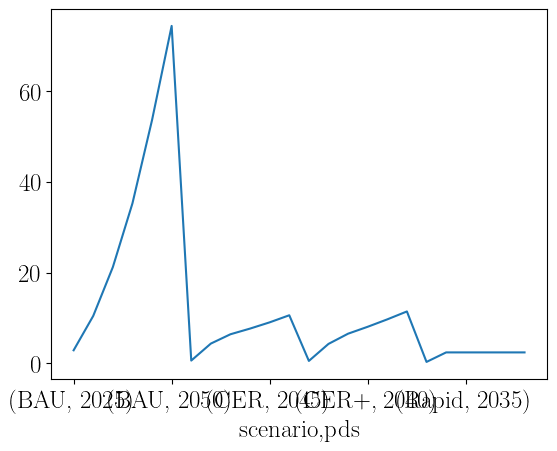

In [34]:

scen_supply_df["Generator"] = scen_supply_df.reset_index()["Type"].apply(tech_agg.get).values
scen_supply_df.groupby(["scenario","pds"])["emissions (Mt)"].sum().groupby("scenario").cumsum().plot()

<Axes: xlabel='pds,aba,Type,h,scenario'>

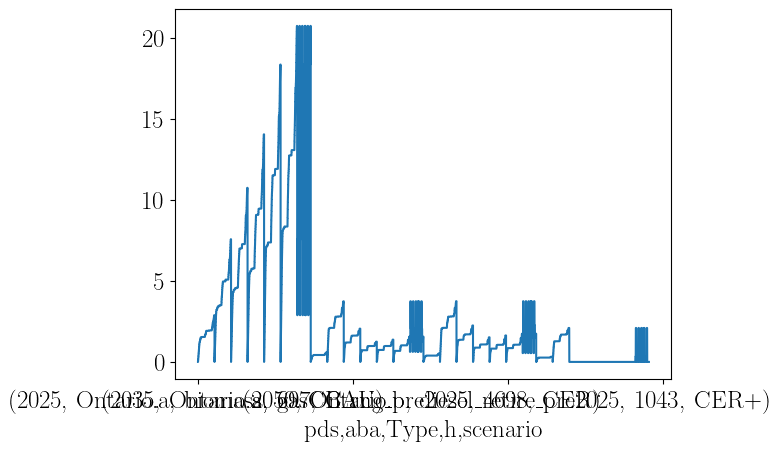

In [35]:

scen_supply_df.groupby(["scenario","pds"])["emissions (Mt)"].cumsum().plot()

## abm adoptions over iterations

In [36]:
import pandas as pd

tech_share_dfs = []
for run_id, result_dir in enumerate(abm_result_dirs):
    df = pd.read_csv(result_dir.joinpath("tech_shares_df.csv"))
    df["run_id"] = run_id
    tech_share_dfs.append(df)

tech_share_df = pd.concat(tech_share_dfs)

# note, that the `RunId` is the batch-RunId of the abm itself
long_tech_shares = tech_share_df.drop("RunId", axis=1).melt(id_vars=["year","province","run_id"])
long_tech_shares.head()

,year,province,run_id,variable,value
0,2020.00,Ontario,0,Gas furnace,0.714
1,2020.25,Ontario,0,Gas furnace,0.714
2,2020.50,Ontario,0,Gas furnace,0.716
3,2020.75,Ontario,0,Gas furnace,0.720
4,2021.00,Ontario,0,Gas furnace,0.722


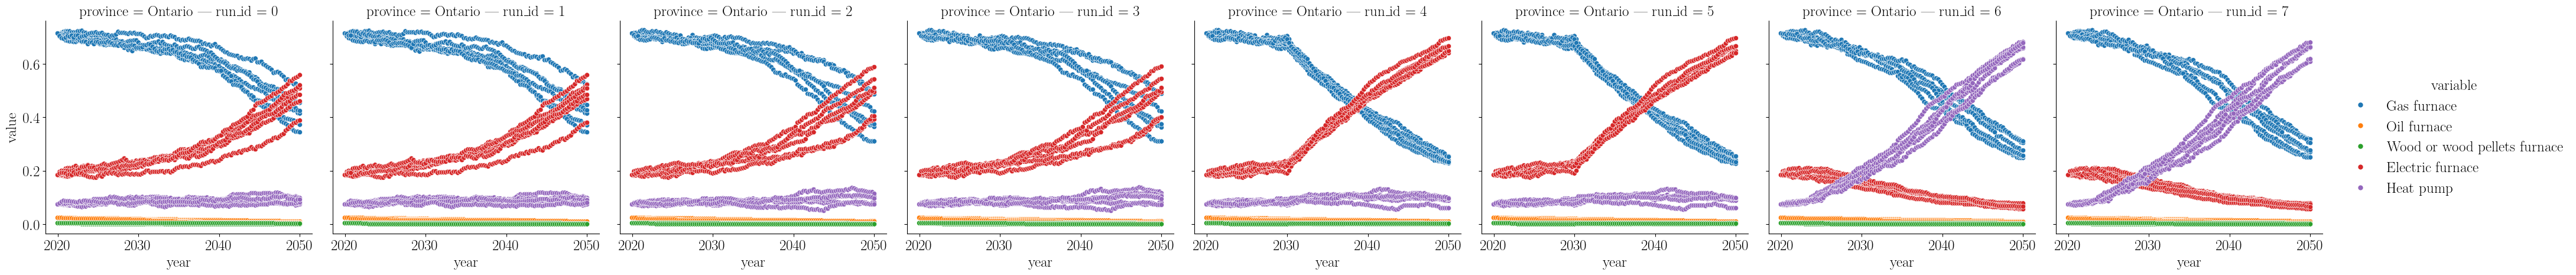

In [37]:
import seaborn as sns

sns.relplot(long_tech_shares, x="year", y="value", hue="variable", col="run_id", row="province")

In [38]:
import pickle
carrier_demands = []
for run_id, result_dir in enumerate(abm_result_dirs):
    df = pickle.load(result_dir.joinpath("mean_carrier_demand.pkl").open("rb"))
    df["run_id"] = run_id
    carrier_demands.append(df)

abm_demands = pd.concat(carrier_demands)

abm_demands.head()

Fuels.NATURAL_GAS Fuels.HEATING_OIL  \
province year   hour                                        
Ontario  2020.0 0     2856837717.333333        97197384.0   
                1     2514491733.333333   85549849.333333   
                2     3102280277.333333       105548000.0   
                3     4366648149.333333  148565253.333333   
                4     3224775125.333333  109715642.666667   

                     Fuels.WOOD_OR_WOOD_PELLETS  Fuels.ELECTRICITY  run_id  
province year   hour                                                        
Ontario  2020.0 0               18871233.833333        705091872.0       0  
                1               16609821.666667   615301546.666667       0  
                2               20492538.333333   763715946.666667       0  
                3               28844497.666667  1090400597.333333       0  
                4               21301699.666667   794650869.333333       0

In [39]:
import plotly.express as px
annual_demands = abm_demands.groupby(["year", "run_id","province"]).sum().reset_index().melt(id_vars=["year","run_id","province"])
annual_demands
# no effect after first change?
fig = px.line(annual_demands, x="year",y="value",color="variable", facet_col="run_id", template="plotly",facet_row="province")
def split_annotation(annot, must_contain="province"):
    if must_contain in annot.text:
        annot.text = annot.text.split("=")[-1]
fig.for_each_annotation(split_annotation)

## Alternative price derivation method
Using LCOE based approach

In [40]:
import toml
config = toml.load(open("copper/scenarios/BAU_scenario/config.toml","r"))
discount = config["Economics"]["discount"]
discount_2050 = config["Economics"]["discount_2050"]
pds = config["Simulation_Settings"]["pds"]
# pds = [int(PD) for PD in config["Simulation_Settings"]["pds"]]

inflation = config["Economics"]["inflation"]


def get_disc_coeff(PD):
    ind = pds.index(PD)
    if ind != (len(pds)-1):
        #We use disc_ann_coef as the coeffecient to bring an n-year series Annuity to a net present value
        first_term = (1/(1+discount)**(int(pds[ind+1])-int(PD)))
        second_term = 1
        third_term = discount
        disc_ann_coef = ((second_term - first_term) / third_term)
        # print(PD, f"{disc_ann_coef=}")
        if (disc_ann_coef < 0):
            # print(disc_ann_coef)
            sys.exit()
        weird_factor = (1/(1+discount)**((int(PD)-1)-2021))
        # print(PD, f"{weird_factor=}")
        # print(weird_factor)
        disc_coef = disc_ann_coef * weird_factor #New, we are using annuity series combined with future value to present value formula
    else:
        disc_coef=(1/(1+discount_2050)**(int(PD)-2021))

    # print(PD, f"{disc_coef=}")
    return disc_coef

def inf_coeff(PD):
    return (1+inflation)**(int(PD)-2021)

disc_coeffs = {PD:get_disc_coeff(PD) for PD in pds}
disc_coeffs

{'2025': 4.016778455471785,
 '2030': 3.343079163194959,
 '2035': 2.7823735900006517,
 '2040': 2.3157102827725193,
 '2045': 1.9273163506907516,
 '2050': 9.962876596086617e-05}

# Copper results

* underlying data is already annuitized and inflation adjusted
* variable costs are scaled up to represent annual cost
* fixed cost are in $/a


## System costs

In [41]:
import toml
import pandas as pd
# from main import get_copper_el_prices, multi_index_copper_demand
from copper.phases.postprocessing import get_all_disc_coeffs
import plotly.express as px

scenario = "CER_scenario"
result_dirs = [
    "copper/results/CER_20240408_1526/CER_scenario_20240408_1540"
]

results_dir = result_dirs[0]
config_path = f"{results_dir}/config.toml"
config = toml.load(config_path)
gridcell_data = pd.read_csv('copper/scenarios/static/gridcells.csv')
map_gl_to_ba=dict(gridcell_data[['grid_cell', 'ba']].values)

disc_coeffs = get_all_disc_coeffs(config)




In [42]:
disc_coeff_series = pd.Series(disc_coeffs).to_frame()
disc_coeff_series.columns = ["dual_price"]
disc_coeff_series.index.set_names(["year"], inplace=True)
disc_coeff_series.index = disc_coeff_series.index.astype(int)

In [43]:
import plotly.express as px
def uncumulate_values(df:pd.DataFrame):
    diff = df[["value"]].diff()
    df.loc[df.pds > 2025,"value"] = diff.loc[df.pds>2025,"value"].values
    df.loc[df["value"]<0,"value"] = 0
    return df


def copper_total_cost_df(result_dir, uncumulate=False):
    cap_cost = pd.read_csv(f"{result_dir}/capcost.csv")
    cap_cost["cost"] = "Invest"
    fom_cost = pd.read_csv(f"{result_dir}/fixOMcost.csv")
    fom_cost["cost"] = "FOM"
    vom_cost = pd.read_csv(f"{result_dir}/varOMcost.csv")
    vom_cost["cost"] = "VOM"
    fuel_cost = pd.read_csv(f"{result_dir}/fuel_cost.csv")
    fuel_cost["cost"] = "Fuels"
    storage_cost = pd.read_csv(f"{result_dir}/newstorage_ccost.csv")
    storage_cost["cost"] = "Storage Invest"
    storage_om_cost = pd.read_csv(f"{result_dir}/newstorage_omcost.csv")
    storage_om_cost["cost"] = "Storage OM"
    hydro_cost = pd.read_csv(f"{result_dir}/hydrorenewalccost.csv")
    hydro_cost["cost"] = "Hydro"
    hydro_om_cost = pd.read_csv(f"{result_dir}/hydrorenewalomcost.csv")
    hydro_om_cost["cost"] = "Hydro"
    if uncumulate:
        cap_cost = uncumulate_values(cap_cost)
        fom_cost = uncumulate_values(fom_cost)
        storage_cost = uncumulate_values(storage_cost)
        storage_om_cost = uncumulate_values(storage_om_cost)
        hydro_cost = uncumulate_values(hydro_cost)
        hydro_om_cost = uncumulate_values(hydro_om_cost)

    total_cost = pd.concat([cap_cost, vom_cost, fom_cost,fuel_cost,storage_cost,storage_om_cost,hydro_cost,hydro_om_cost])
    return total_cost   

total_cost = copper_total_cost_df(results_dir, uncumulate=False)
total_cost["cost_type"] = "undiscounted"
total_adapted_cost = total_cost.copy()
total_adapted_cost["cost_type"] = "discounted"
total_adapted_cost["value"] = total_cost["value"] * total_cost["pds"].astype(str).apply(disc_coeffs.get)

total_cost = pd.concat([total_cost, total_adapted_cost])

# total_cost
fig = px.bar(total_cost, x="pds", y="value",color="cost", facet_row="cost_type", template="plotly")
fig.update_layout(width=700, legend_traceorder="reversed")
fig.write_html(f"{results_dir}/investments.html")
fig.write_image(f"{results_dir}/investments.png")
fig

In [44]:
cost_dfs = []
for scenario in result_df.Scenario.unique():
    path = result_df.query(f"iteration==1 and Scenario=='{scenario}'")["ESM path"].values[0]
    cost_df = copper_total_cost_df(path)
    cost_df["scenario"] = scenario
    cost_dfs.append(cost_df)

scen_cost_df = pd.concat(cost_dfs)
scen_cost_agg = scen_cost_df.groupby(["scenario","cost"])["value"].sum().reset_index().pivot(columns="scenario", index="cost", values="value")
fig = px.bar(scen_cost_agg.T, template="plotly")
# scen_cost_agg.loc["total",:] = scen_cost_agg.sum()
fig

In [45]:
scen_copper_emissions_agg = scen_supply_df.groupby("scenario")["emissions (Mt)"].sum()
scen_copper_emissions_reduction = scen_copper_emissions_agg["BAU"] - scen_copper_emissions_agg
scen_copper_emissions_reduction

scenario
BAU       0.000000
CER      63.744829
CER+     62.904833
Rapid    71.925792
Name: emissions (Mt), dtype: float64

In [46]:
scen_cost_agg.sum()*1e-6/scen_copper_emissions_reduction

scenario
BAU              inf
CER      1074.030456
CER+     1176.321622
Rapid     953.488824
dtype: float64

In [47]:
scen_cost_agg.sum()*1e-6

scenario
BAU      64148.528810
CER      68463.887466
CER+     73996.315096
Rapid    68580.438690
dtype: float64

In [48]:
scen_supply_df.groupby(["pds","scenario"])["value"].sum()

pds   scenario
2025  BAU         4.814190e+06
      CER         4.594817e+06
      CER+        4.580228e+06
      Rapid       4.523242e+06
2030  BAU         5.874233e+06
      CER         5.612840e+06
      CER+        5.613946e+06
      Rapid       5.539596e+06
2035  BAU         7.617009e+06
      CER         8.298938e+06
      CER+        9.038776e+06
      Rapid       1.010188e+07
2040  BAU         9.338149e+06
      CER         1.085014e+07
      CER+        1.218302e+07
      Rapid       1.386477e+07
2045  BAU         1.099746e+07
      CER         1.381893e+07
      CER+        1.527580e+07
      Rapid       1.796991e+07
2050  BAU         1.228960e+07
      CER         1.568266e+07
      CER+        1.690472e+07
      Rapid       2.011763e+07
Name: value, dtype: float64